<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Анализ-данных-и-базовые-статистики" data-toc-modified-id="Анализ-данных-и-базовые-статистики-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных и базовые статистики</a></span></li><li><span><a href="#Визуализация-аномалий" data-toc-modified-id="Визуализация-аномалий-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Визуализация аномалий</a></span><ul class="toc-item"><li><span><a href="#Выброс-вверх" data-toc-modified-id="Выброс-вверх-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Выброс вверх</a></span></li><li><span><a href="#Выброс-вниз" data-toc-modified-id="Выброс-вниз-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Выброс вниз</a></span></li><li><span><a href="#Дубликаты" data-toc-modified-id="Дубликаты-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Дубликаты</a></span></li></ul></li><li><span><a href="#Гипотезы-определения-аномалий" data-toc-modified-id="Гипотезы-определения-аномалий-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Гипотезы определения аномалий</a></span></li><li><span><a href="#ML-модель" data-toc-modified-id="ML-модель-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>ML модель</a></span><ul class="toc-item"><li><span><a href="#Определение-базовой-точности-и-критериев-качества-модели" data-toc-modified-id="Определение-базовой-точности-и-критериев-качества-модели-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Определение базовой точности и критериев качества модели</a></span></li><li><span><a href="#Подготовка-дополнительных-признаков" data-toc-modified-id="Подготовка-дополнительных-признаков-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Подготовка дополнительных признаков</a></span></li><li><span><a href="#Разбиение-train/test-&amp;-стратегия-кросс-валидации" data-toc-modified-id="Разбиение-train/test-&amp;-стратегия-кросс-валидации-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Разбиение train/test &amp; стратегия кросс-валидации</a></span></li><li><span><a href="#Оценка-оптимальной-глубины-бустинга" data-toc-modified-id="Оценка-оптимальной-глубины-бустинга-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Оценка оптимальной глубины бустинга</a></span><ul class="toc-item"><li><span><a href="#Тюнинг-гиперпараметров" data-toc-modified-id="Тюнинг-гиперпараметров-5.4.1"><span class="toc-item-num">5.4.1&nbsp;&nbsp;</span>Тюнинг гиперпараметров</a></span></li></ul></li><li><span><a href="#Проверка-качества-модели" data-toc-modified-id="Проверка-качества-модели-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Проверка качества модели</a></span></li><li><span><a href="#Анализ-ошибок" data-toc-modified-id="Анализ-ошибок-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>Анализ ошибок</a></span></li><li><span><a href="#Потенциал-улучшения" data-toc-modified-id="Потенциал-улучшения-5.7"><span class="toc-item-num">5.7&nbsp;&nbsp;</span>Потенциал улучшения</a></span></li></ul></li></ul></div>

# Загрузка данных

Прочитать данные и сформировать датафрейм с идентификатором, признаком (или признаками) и таргетом

In [1]:
# !ls .
# anomaly.csv    Solutions_DS.ipynb  Test_work_ds.ipynb
# data_test.csv  test_mySQL.sql	   utils.py

In [2]:
# !lsb_release -a
# Distributor ID: Ubuntu
# Description:    Ubuntu 18.04.5 LTS
# Release:        18.04
# Codename:       bionic

In [3]:
# !python --version
# Python 3.9.6

In [4]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import expit
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, plot_roc_curve
from shap import TreeExplainer, summary_plot, Explanation, Explainer
from shap.plots import scatter, bar, beeswarm, waterfall
%matplotlib inline

2021-08-23 04:50:48.946973: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [5]:
data = pd.read_csv('data_test.csv', sep="\t")
len(data)

7514

In [6]:
data['id'] = range(len(data))
data.sort_values('timestamp_minutes5', inplace=True)
anomaly = pd.read_csv('anomaly.csv', sep="\t")
len(anomaly)

123

In [7]:
# remove duplicates to avoid doubling records when merging
anomaly.drop_duplicates(inplace=True)
anomaly['anomaly'] = 1
out = pd.merge(data, anomaly, how="left").fillna(0)
out['time'] = pd.to_datetime(out['timestamp_minutes5'], unit='s')
out.drop('timestamp_minutes5', axis=1, inplace=True)
#sanity check
len(out), out['anomaly'].sum()

(7514, 123.0)

In [8]:
out.head()

,sum_count,id,anomaly,time
0,31466984.0,0,0.0,2019-05-31 21:00:00
1,29108251.0,1,0.0,2019-05-31 21:05:00
2,28475443.0,2,0.0,2019-05-31 21:10:00
3,27278641.0,3,0.0,2019-05-31 21:15:00
4,26539619.0,4,0.0,2019-05-31 21:20:00


Согласно задания датафрейм `out` содержит:   
   - Уникальный идентификатор записи: `id` (совпадает с порядковым номером строки в исходном текстовом файле)
   - Признаки:   
        - `sum_count`
        - `time`: объект типа `datetime`  
   - Таргет: `anomaly`
   
Датафрейм упорядочен по возрастанию времени

# Анализ данных и базовые статистики

Датасет не сбалансирован, что повлиет на выбор метрик при тренировке и оценке модели:

In [9]:
out['anomaly'].value_counts()

0.0    7391
1.0     123
Name: anomaly, dtype: int64

In [10]:
out['anomaly'].mean()

0.016369443705083843

Распределение `sum_count` представляет собой временной ряд с сезонностью и нисходящим трендом:

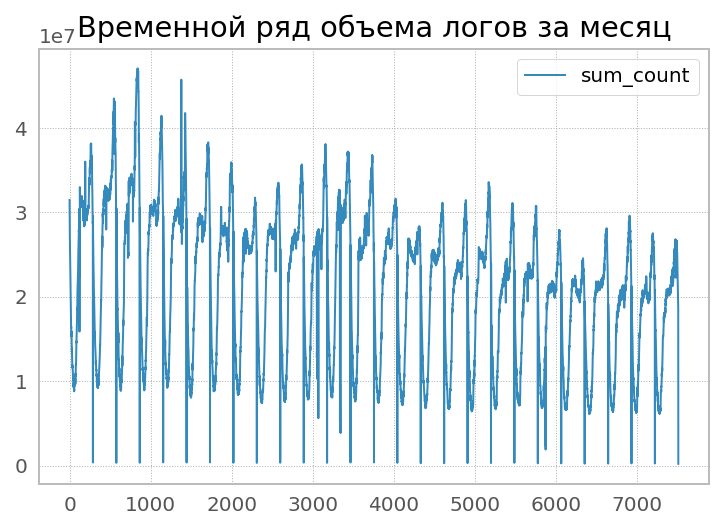

In [11]:
out['sum_count'].plot(label='sum_count')
plt.legend()
plt.title("Временной ряд объема логов за месяц");

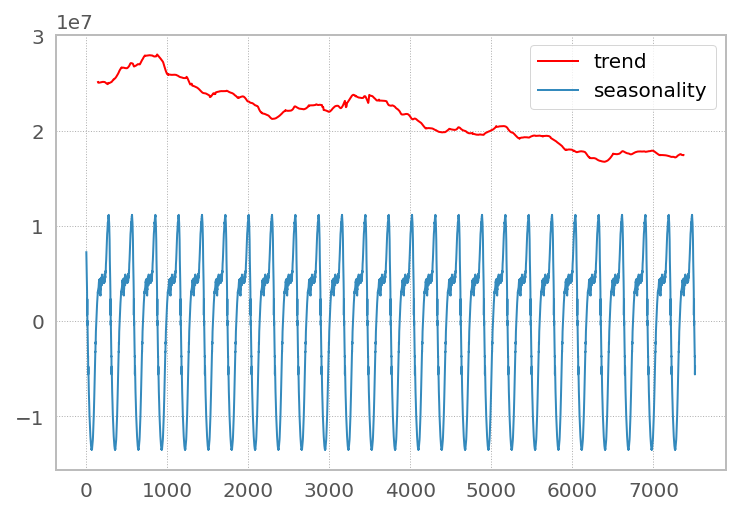

In [12]:
import statsmodels.api as sm
S = sm.tsa.seasonal_decompose(out['sum_count'], period=12*24)
plt.plot(S.trend, label='trend', c='red')
plt.plot(S.seasonal, label = 'seasonality')
plt.legend();

ADF тест на стационарность:

In [13]:
from statsmodels.tsa.stattools import adfuller
adfuller(out['sum_count'].values, regression='ct')

(-12.195037296967255,
 1.8851456374799966e-19,
 31,
 7482,
 {'1%': -3.959980492103089,
  '5%': -3.4110769564967938,
  '10%': -3.1273956462165384},
 237561.194460825)

Интерпретация:  

- Основная гипотеза: процесс содержит единичный корень  
- Альтернативная гипотеза: процесс с отличным от 0 средним и трендом не содержит единичного корня  
- ADF статистика `-12.4`    
- Критическая величина при уровне значимиости `1%` `-3.96`  
- p-value `1.88e-19`  
- При заданном уровне значимости отвергаем $H_0$: процесс не содержит единичный корень (т.е. это стационарный процесс с трендом)

Средняя величина `sum_count` на наблюдаемом временном промежутке:

In [14]:
out['sum_count'].mean()

21520295.106867183

Дисперсия:

In [15]:
out['sum_count'].std()

8580379.707961457

Частотное распределение `sum_count`:
   - не обладает выраженной структуррой   
   - имеет несколько пиков    
   - не подходит под какое либо стандартное распределение   
    
что говорит о том, что данное распределение является суммой нескольких, возможно, нормальных распределений:

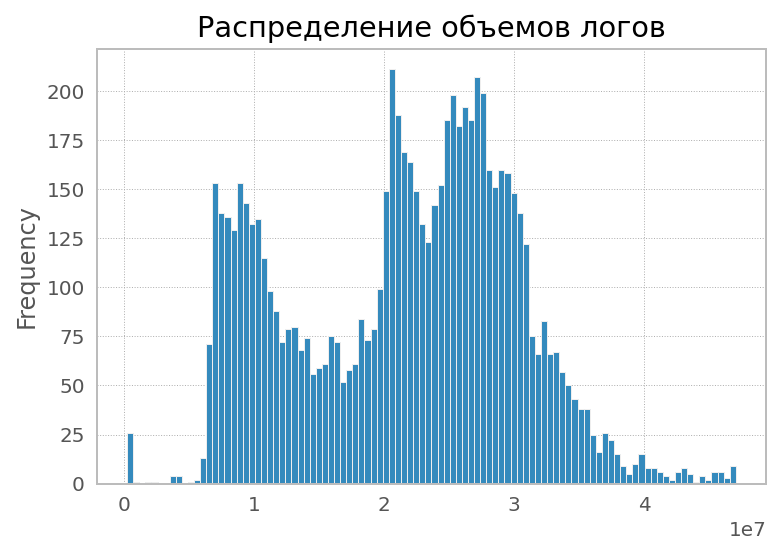

In [16]:
out['sum_count'].plot(kind='hist', bins=100)
plt.title('Распределение объемов логов');

Следующие 2 графика подтверждают это предположение:

- Распределение объемов логов имеет выраженную суточную структуру  
- Рапределение объемов логов внутри часа имеет более гомогенную структуру, по сравнению с распределением на всем временном промежутке. Распределение внутри некоторых часов близко к нормальному  
- На графиках хорошо видны аномалии  

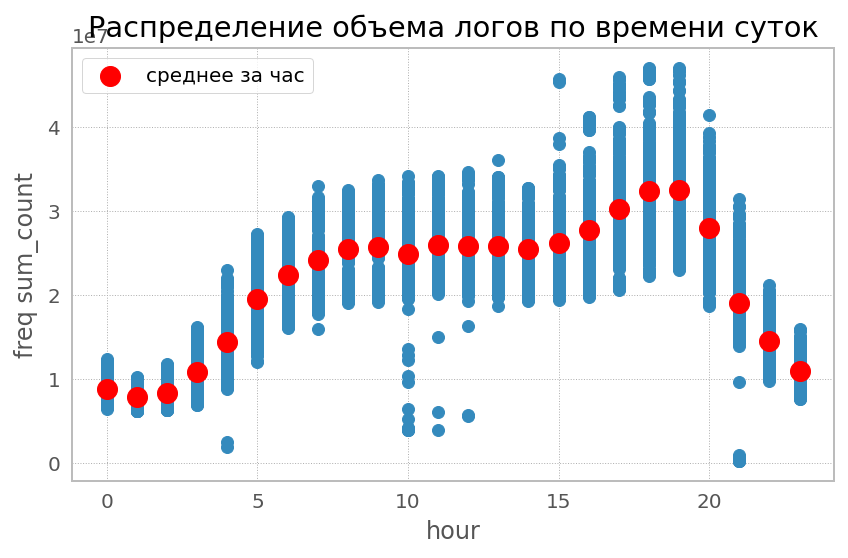

In [17]:
plt.scatter(out['time'].dt.hour, out['sum_count'])
plt.xlabel('hour')
plt.ylabel('freq sum_count')
means = out.groupby(out['time'].dt.hour)['sum_count'].agg("mean")
plt.scatter(means.index, means, c='red',label='среднее за час', s=100)
plt.title("Распределение объема логов по времени суток")
plt.legend()
plt.tight_layout();
# TODO 
# add CI

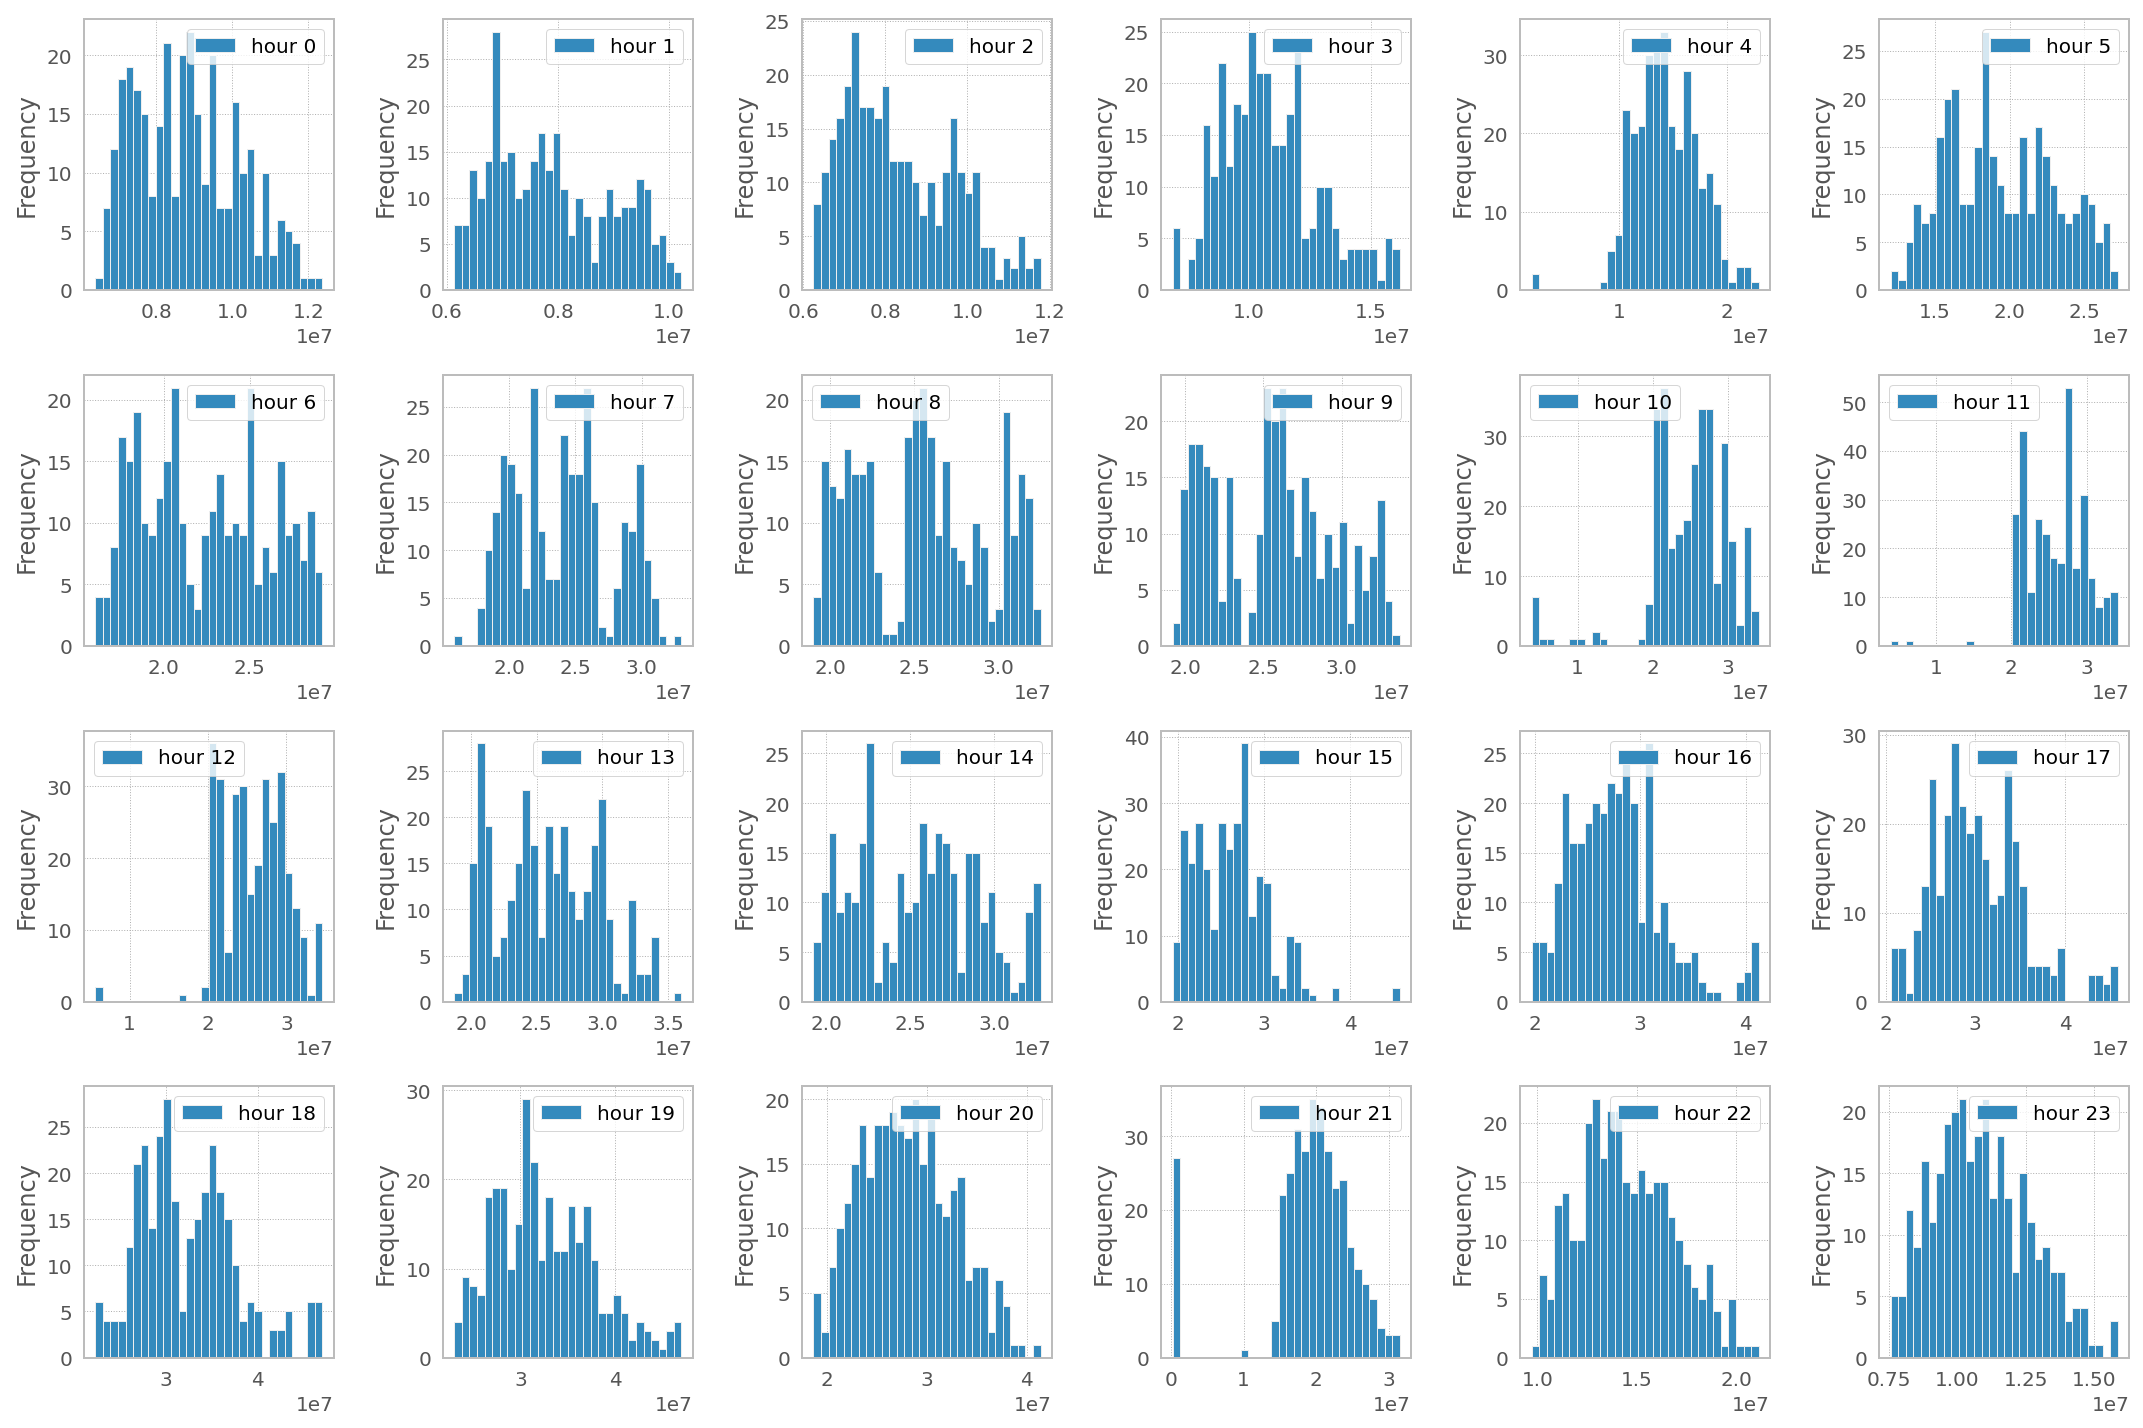

In [18]:
groups = out.groupby(out['time'].dt.hour)['sum_count']
fig,axes = plt.subplots(4,6, figsize=(15,10))
for key, ax in zip(groups.groups.keys(), axes.ravel()):
    groups.get_group(key).plot(ax=ax, label=f"hour {key}", kind='hist', bins=30)
    ax.legend()
plt.tight_layout();

Распределение запросов внутри некоторых часов напоминает нормальное распределение, но все же распределения далеки от нормального U-shaped распределения. Это отчасти объясняется наличием тренда:

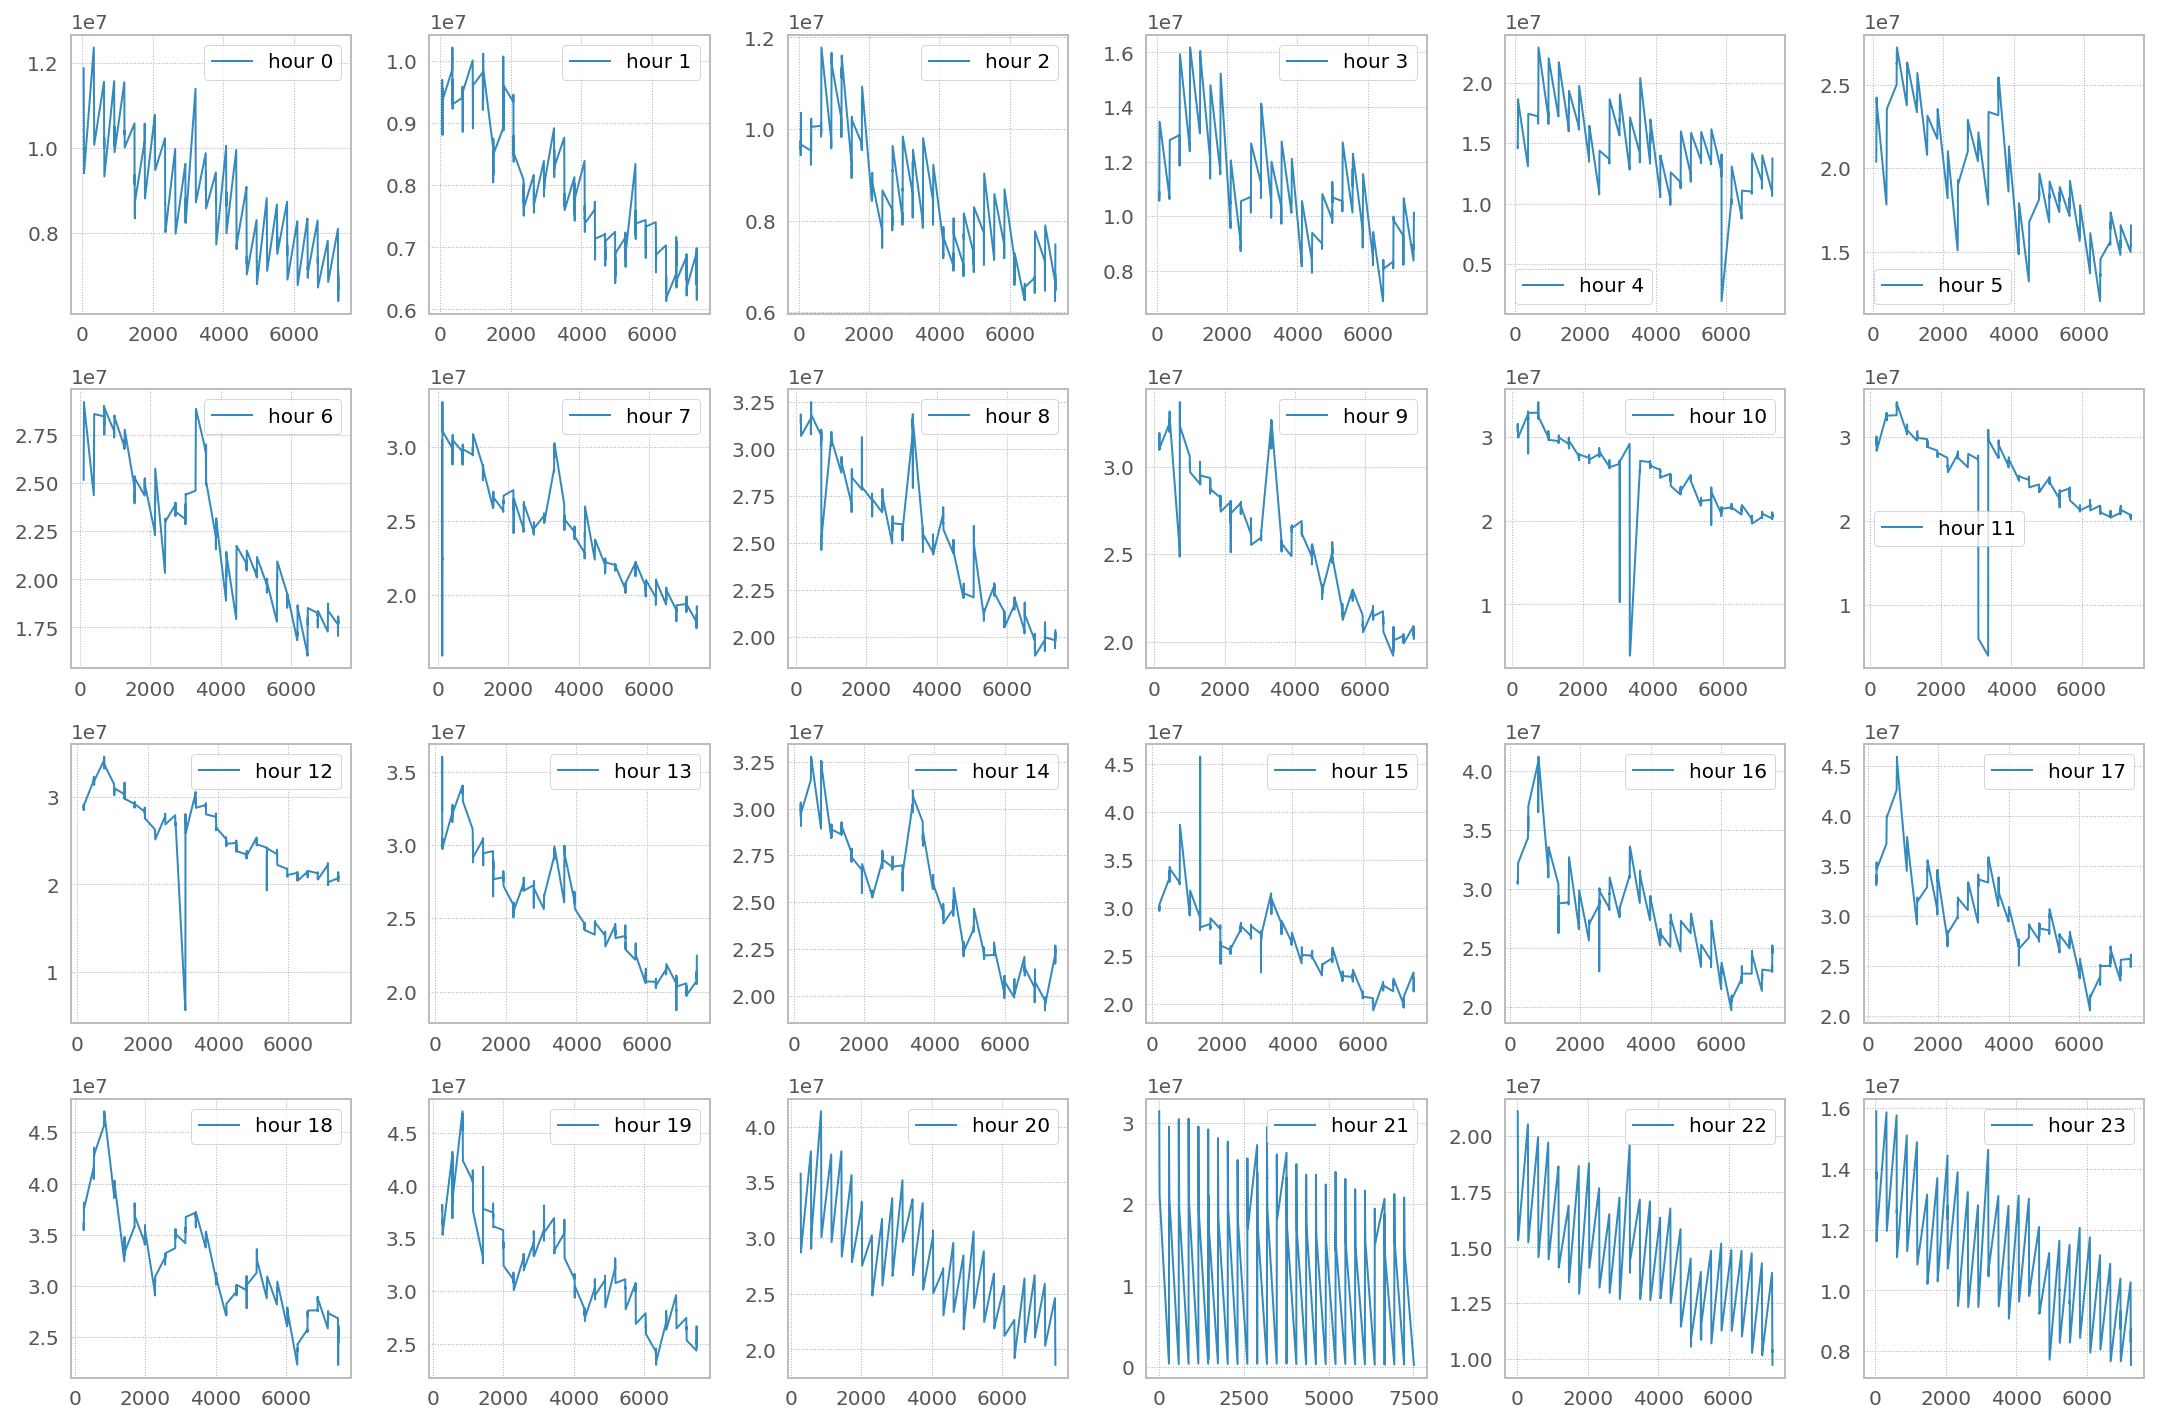

In [19]:
fig,axes = plt.subplots(4,6, figsize=(15,10))
for key, ax in zip(groups.groups.keys(), axes.ravel()):
    groups.get_group(key).plot(ax=ax, label=f"hour {key}")
    ax.legend()
plt.tight_layout();

Распределение количества аномалий по часам:

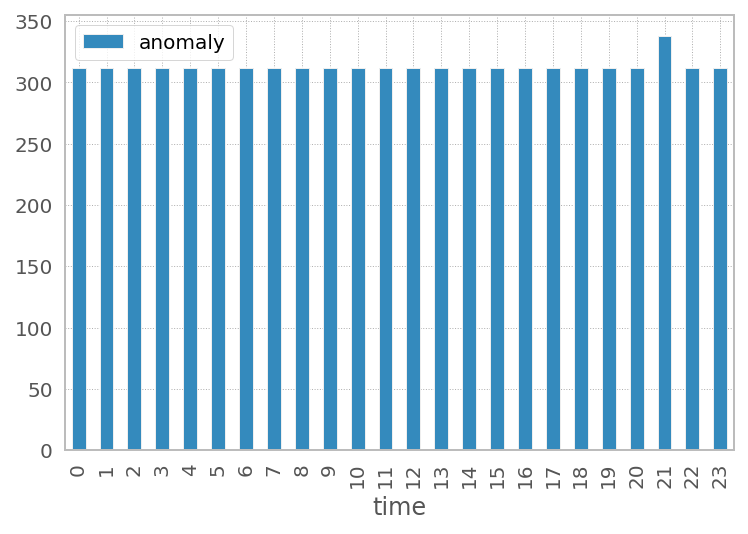

In [20]:
out.groupby(out['time'].dt.hour).agg({'anomaly':'count'}).plot(kind='bar');

In [21]:
out.groupby(out['time'].dt.hour).agg({'anomaly':'count'}).value_counts()

anomaly
312        23
338         1
dtype: int64

Факт преобладания 23-ех аномалий в час говорит, скорее всего, об искусственном происхождение данного датасета ("синтетический" датасет)

# Визуализация аномалий

Для предсказания аномалий важно понимать, что дубликат однозначно признается аномалией (согласно условий задачи), тогда как отсутствие дубликата не гарантирует, что данное наблдение не будет признано аномалией:

In [22]:
out['dupe'] = out.groupby('time')['anomaly'].transform(lambda x: len(x)>1)
pd.crosstab(out['anomaly'], out['dupe'], margins=True)

dupe,False,True,All
anomaly,,,
0.0,7391,0,7391
1.0,73,50,123
All,7464,50,7514


На текущем этапе дабавим метку "дубликат" в датасет.  

Визуализируем аномалии при помощи кастомной функции `plot_logs`.

На вход подается датафрейм, содержащий столбцы `sum_count`, `time`, `anomaly`, `dupe`. Тип `pd.DataFrame` и наличие столбцов проверяется, с сооствествующим сообщением об ошибке в случае не соблюдения условия. Результатом исполнеия функции является:

1. график временного ряда с отображаением периода, в котором наблюдается аномалия
2. matplotlib `Axes` объект, что позволяет дорисовывать сверху произвольные объекты (например скользящие средние, доверительные интервалы, предсказания и т.д.)

Аномальные точки помечаются красным. Дубликаты помечаются желтой окружностью (опционально).

Описание параметров можно посмотреть `plot_logs?` (после импорта функии из файла `utils.py` в текущей директории)

In [23]:
# !cat utils.py

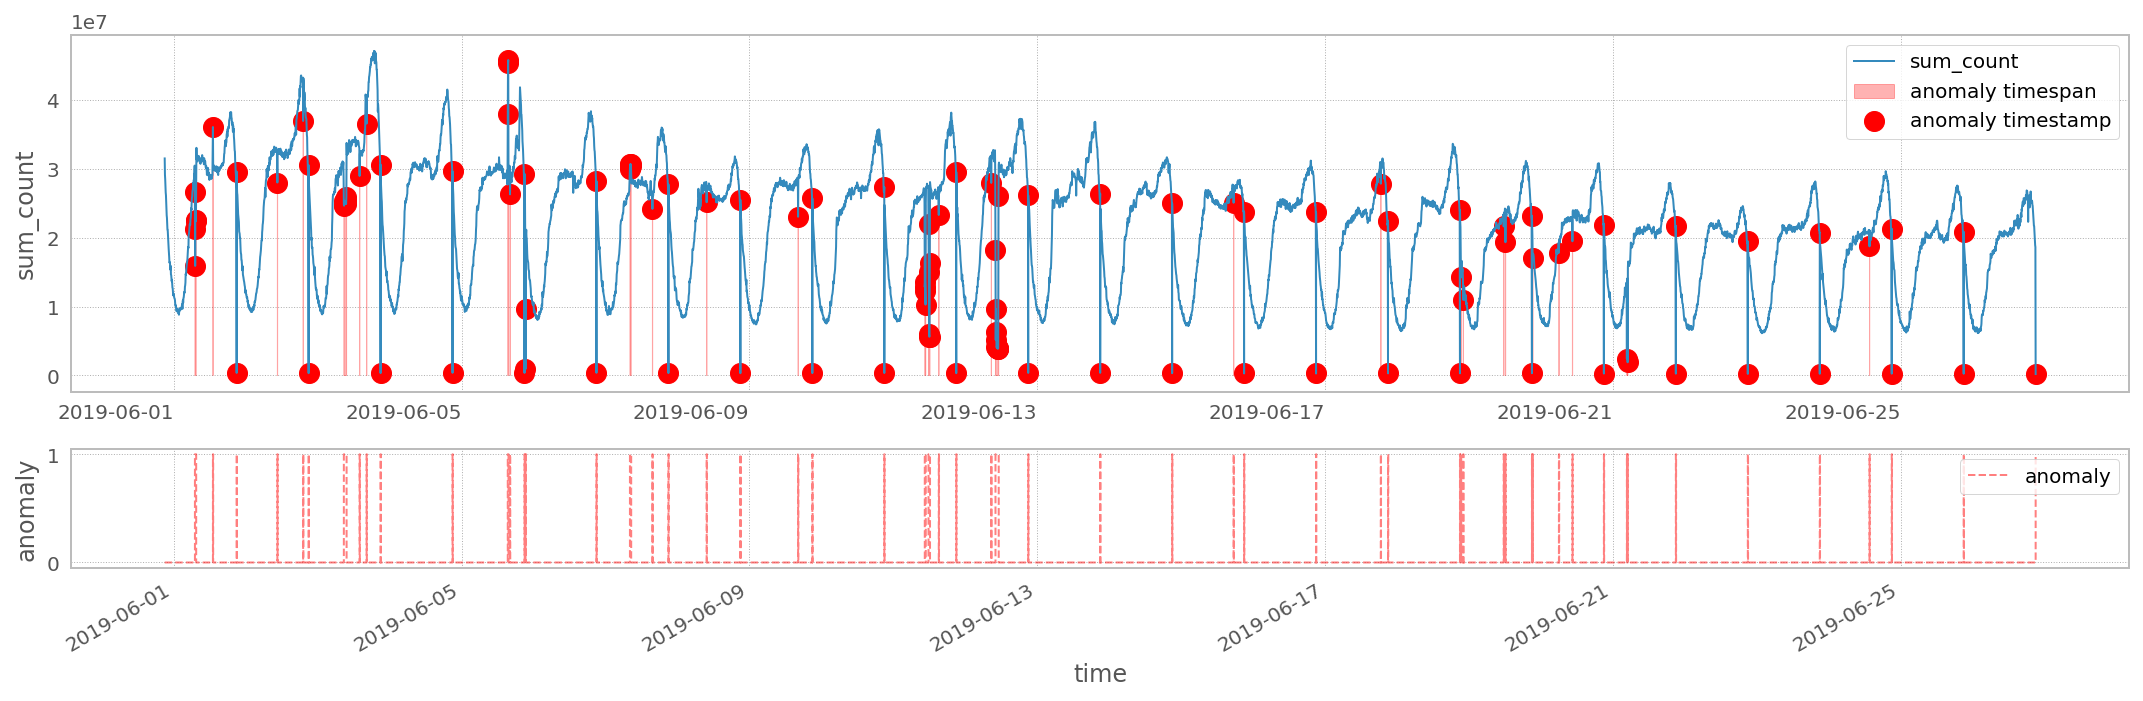

In [24]:
from utils import plot_logs
plot_logs(out, dupe=False);

Можно выделить 3 характерные категории аномалий

## Выброс вверх

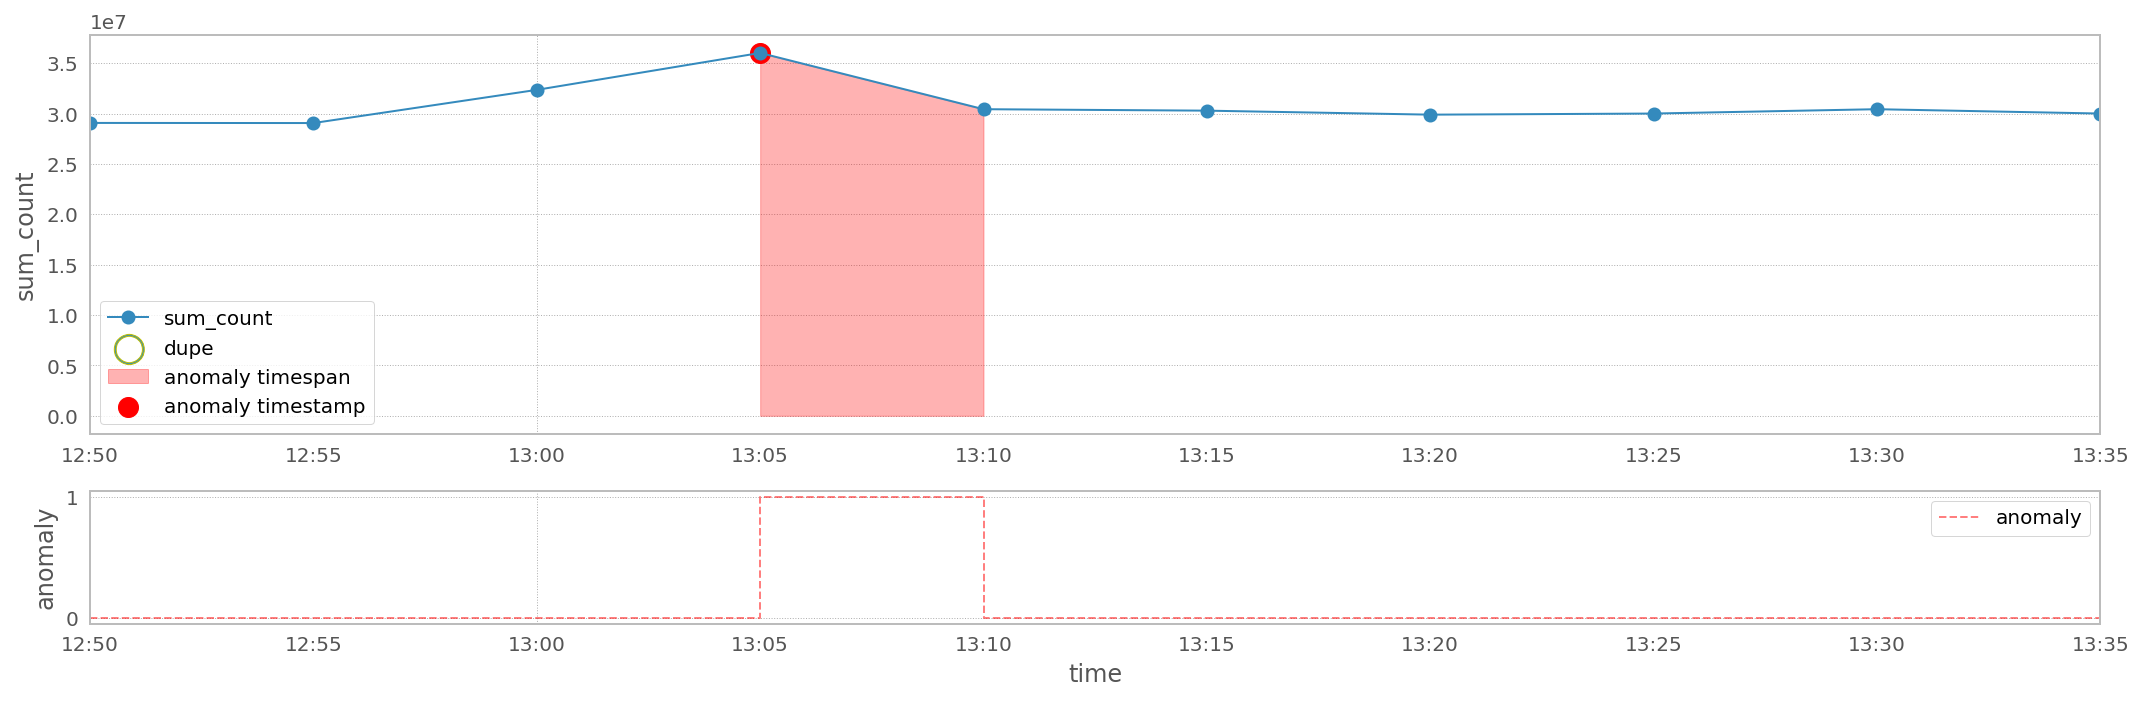

In [25]:
plot_logs(out, start=190, end=200);

Интерпретация: 

   - верхний график: наблюдаемая величина
        - `sum_counts`: наблюдаемая величина, синия линия, точки наблюдения помечены синим маркером (не используется при >100 наблюдений)
        - `anomaly timestamp`: красная точка, таймстэмп, отмечающий начало 5-ти минутного периода аномалии
        - `dupe`: желтая окружность вокруг маркера аномалии, который является аномалией, опиционально, True по умолчанию.
        - `anomaly timespan`: временной промежуток, в котором наблюдалась аномалия (от начала до конца аномалии), подкрашенный розовым (отключается в `overlay='dot'`)
        
   - нижний график: ступенька временного промежутка, в котором наблюдается аномалия

## Выброс вниз

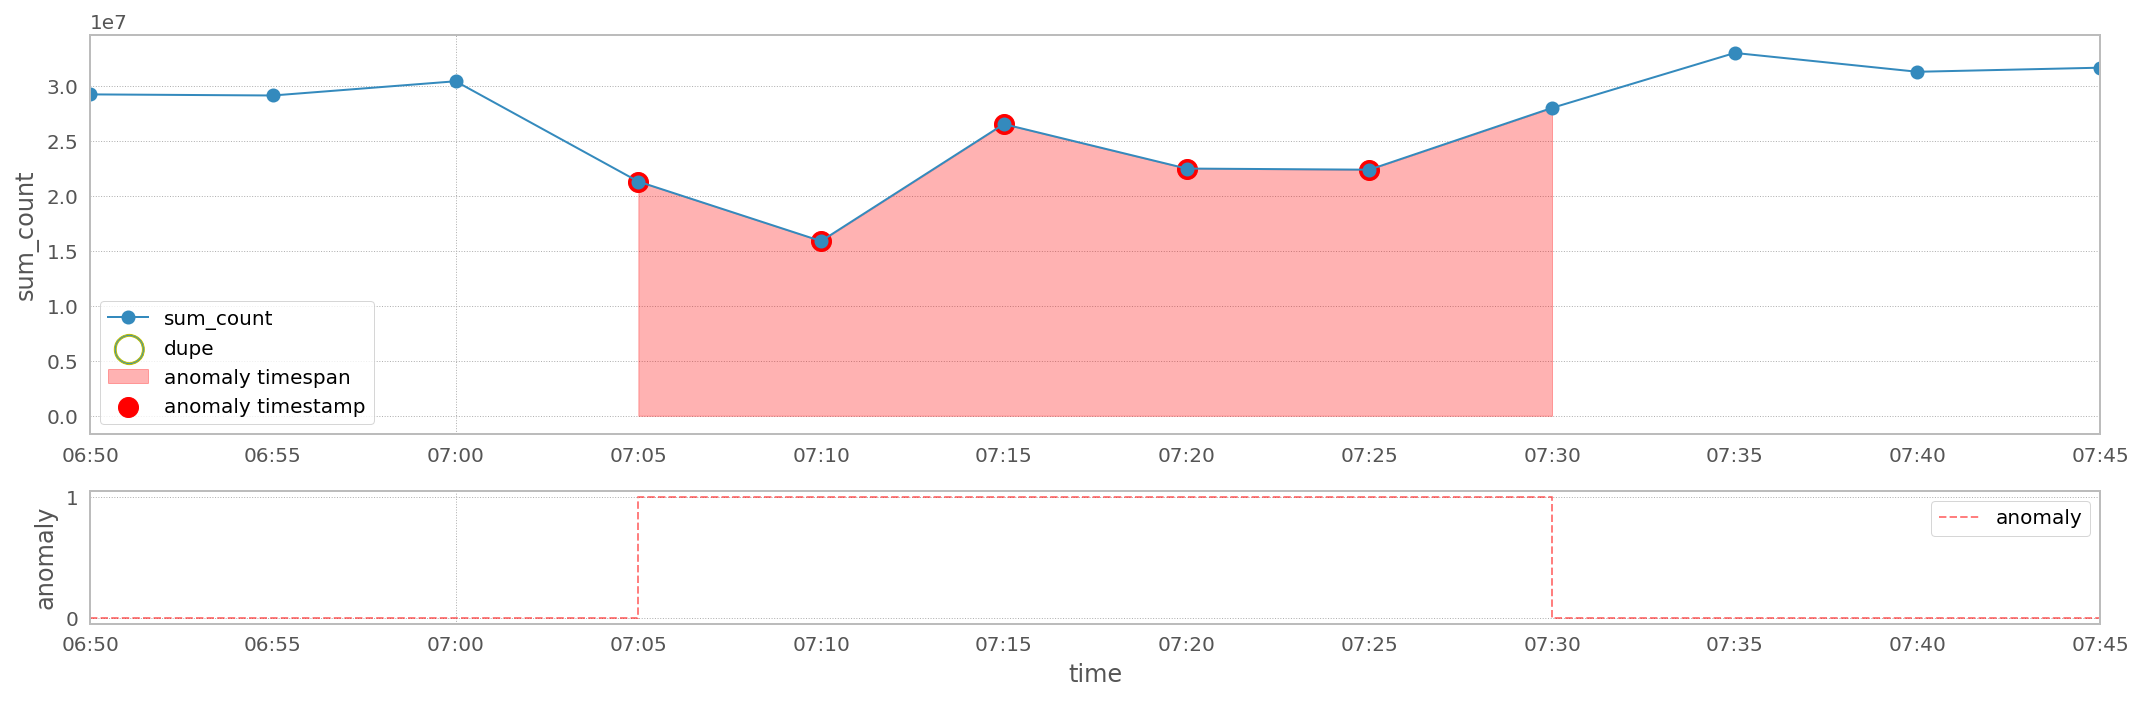

In [26]:
plot_logs(out, start=118, end=130);

> Последняя точка аномального периода не помечена как аномальная, т.к. не является таковой по условию задачи!

Проверка:

In [27]:
out[118:130]

,sum_count,id,anomaly,time,dupe
118,29234876.0,118,0.0,2019-06-01 06:50:00,False
119,29134860.0,119,0.0,2019-06-01 06:55:00,False
120,30428747.0,120,0.0,2019-06-01 07:00:00,False
121,21304145.0,121,1.0,2019-06-01 07:05:00,False
122,15889877.0,122,1.0,2019-06-01 07:10:00,False
123,26532889.0,123,1.0,2019-06-01 07:15:00,False
124,22487674.0,124,1.0,2019-06-01 07:20:00,False
125,22384027.0,125,1.0,2019-06-01 07:25:00,False
126,28002803.0,126,0.0,2019-06-01 07:30:00,False
127,33005133.0,127,0.0,2019-06-01 07:35:00,False


## Дубликаты

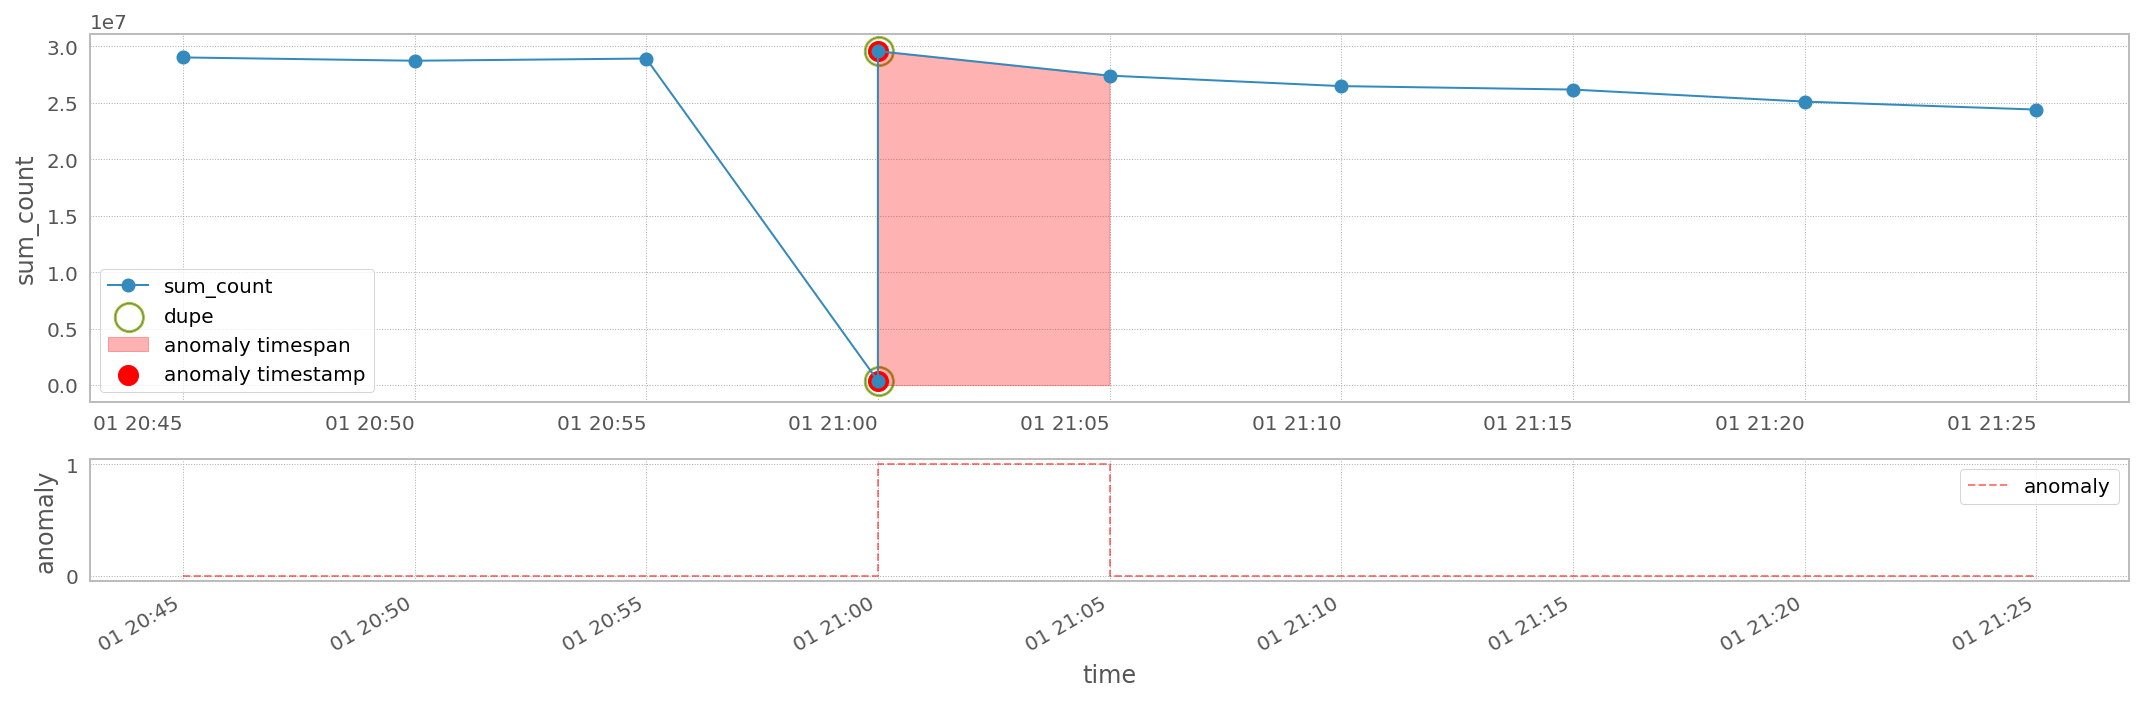

In [28]:
plot_logs(out, start=285, end=295);

In [29]:
out[285:295]

,sum_count,id,anomaly,time,dupe
285,29004390.0,285,0.0,2019-06-01 20:45:00,False
286,28711392.0,286,0.0,2019-06-01 20:50:00,False
287,28905332.0,287,0.0,2019-06-01 20:55:00,False
288,374142.0,288,1.0,2019-06-01 21:00:00,True
289,29557885.0,289,1.0,2019-06-01 21:00:00,True
290,27392806.0,290,0.0,2019-06-01 21:05:00,False
291,26464934.0,291,0.0,2019-06-01 21:10:00,False
292,26158675.0,292,0.0,2019-06-01 21:15:00,False
293,25094027.0,293,0.0,2019-06-01 21:20:00,False
294,24387791.0,294,0.0,2019-06-01 21:25:00,False


Интерпретация:

    - 5-ти минутный период начиная с 21:00 помечен как аномальный  
    - 2 дубликата с одинаковой временной меткой помечены желтой окружностью
    
> Данный график дополнительно объясняет решение о введении фичи `dupe`. Дубликаты не просто можно определить как `anomaly` простым счетом, но один из 2ух дубликатов практически не отличим по амплитуде от "нормального", ожидаемого значение ("нормальное" можно определить как скользящая среднее, см. ниже).  

Следует заметить, что дубликаты имеют еще одну характерную особенность: все дубликаты происходят (i) каждый день (ii) в 21:00 что является еще одним аргументом в пользу того, что это синтетический датасет

In [30]:
out.groupby('time').filter(lambda x: len(x)>1)['time'].drop_duplicates()

288    2019-06-01 21:00:00
577    2019-06-02 21:00:00
866    2019-06-03 21:00:00
1155   2019-06-04 21:00:00
1444   2019-06-05 21:00:00
1733   2019-06-06 21:00:00
2022   2019-06-07 21:00:00
2311   2019-06-08 21:00:00
2600   2019-06-09 21:00:00
2889   2019-06-10 21:00:00
3178   2019-06-11 21:00:00
3467   2019-06-12 21:00:00
3756   2019-06-13 21:00:00
4045   2019-06-14 21:00:00
4334   2019-06-15 21:00:00
4623   2019-06-16 21:00:00
4912   2019-06-17 21:00:00
5201   2019-06-18 21:00:00
5490   2019-06-19 21:00:00
5779   2019-06-20 21:00:00
6068   2019-06-21 21:00:00
6357   2019-06-22 21:00:00
6646   2019-06-23 21:00:00
6935   2019-06-24 21:00:00
7224   2019-06-25 21:00:00
Name: time, dtype: datetime64[ns]

# Гипотезы определения аномалий

Исходя из визульного анализа данных можно сформулировать ряд гипотез, по определению аномалий на основе доступных статистик:

- Время 21:00 является статистически значимым предиктором аномалии
- Для данного часа $H \in [0,24)$ точка находящая за пределами $\mu_H \pm 3*\sigma_H$ является аномальной. Учитывая тренд, оптимальным представляется брать $\mu_H$ и $\sigma_H$ не за весь период, а за несколько предществующих дней.
- Отклонение объема логов от скользящей средней на $3*\sigma$ является статистически значимым предиктором аномалии.

Проверим первое утверждение:

1. Основная гипотеза $H_0$: время 21:00 не является статистически значимым предиктором. В 5-ти минутный промежуток времени с 21:00 до 21:05 мы получим такую же частоту аномалий, как и на остальной выборке.
2. Альтернативная гипотеза $H_A$: частота распределения в данный промежуток выше, чем в остальных временных промежутках.
3. Уровень значимости $\alpha=.01$
4. Используем Z-статистику, односторонний тест: $\text{z_score}_{critical} = 2.33$. Критерий отвержения основной гипотезы: превышение рассчитанной статистики над критическим значением.

Рассчитаем Z-статистику для наших данных.

In [31]:
experiment_mask = (out['time'].dt.hour == 21) & (out['time'].dt.minute == 0)
control = out[~experiment_mask].copy()
experiment = out[experiment_mask].copy()
control_mean = control['anomaly'].mean()
experiment_mean = experiment['anomaly'].mean()
control_var = control_mean*(1-control_mean)
experiment_var = experiment_mean*(1-experiment_mean)
Z_score = (experiment_mean - control_mean)/np.sqrt(control_var/len(control)+experiment_var/len(experiment))
Z_score

50.90115826918899

Т.к. `50.9>2.33` ==> отвергаем основную гипотезу на данном уровне значимости и принимаем альтернативную

Следует заметить, что вероятность получить "не аномалию" в 21:00 в нашем эксперименте равна 0:

In [32]:
import scipy.stats as st
control_mean = 0.
control_var = control_mean*(1-control_mean)
experiment_var = experiment_mean*(1-experiment_mean)
Z_score = (experiment_mean - control_mean)/np.sqrt(control_var/len(control)+experiment_var/len(experiment))
st.norm.sf(Z_score)

0.0

# ML модель

## Определение базовой точности и критериев качества модели

Базовая точность определяется назначением всем логам преобладающего класса 0:

In [33]:
1-out['anomaly'].mean()

0.9836305562949161

Т.к. датасет является сильно несбалансированным, помимо превышения точности ("accuracy") модели над базовой точности, основными критериями качества модели является:   

- `AUC ROC`  
- Точность (`Precision`)  
- Чувствительность (`Recall`)  

Если `AUC ROC` является интегральной оценкой качества модели, то `Precision` и `Recall` зависят от порога перевода вероятности в дискретный класс 1 (аномалия) или 0 (отсутствие аномалии), и определяются балансом стоимости для бизнеса принятия истинно положительных, ложно положительных, и ложно отрицательных решений.   

## Подготовка дополнительных признаков

Все разницы нормированы на дисперсию. В подготовке всех признаков используется ТОЛЬКО история:

> Важно!        
>
> Для каждой точки используются только данные из прошлого (чтобы предотвратить **data leakage**)

diff - разница между текущим значением и EWMA   
diff_5_min, diff_10_min, diff_15_min, diff_20_min, diff_25_min, diff_30_min, diff_24_h - разница между текущим значением `sum_count` и значение `sum_count` минус 5,10,15, 20, 25, 30 минут и 24 часа.

In [34]:
# out.reset_index(inplace=True)
WINDOW = 10
# warmup
mn = out["sum_count"][:1000].mean()
std = out["sum_count"][:1000].std()
out['dupe'] = out['dupe'].astype('float')
out["minute"] = out["time"].dt.minute
out["hour"] = out["time"].dt.hour
out["wday"] = out["time"].dt.day_of_week
rolling_std = out["sum_count"].rolling(WINDOW).std().fillna(std)
out["ewma"] = (
    out["sum_count"]
    .ewm(span=20, min_periods=0, adjust=False, ignore_na=False)
    .mean()
)
out["diff_20"] = (out["sum_count"] - out["ewma"]) / rolling_std

out["ewma_10"] = (
    out["sum_count"]
    .ewm(span=10, min_periods=0, adjust=False, ignore_na=False)
    .mean()
)
out["diff_10"] = (out["sum_count"] - out["ewma_10"]) / rolling_std
out["ewma_30"] = (
    out["sum_count"]
    .ewm(span=30, min_periods=0, adjust=False, ignore_na=False)
    .mean()
)
out["diff_30"] = (out["sum_count"] - out["ewma_30"]) / rolling_std

for i in [1, 2, 3, 4, 5, 6]:
    out[f"diff_{i*5}_min"] = (out["sum_count"] - out["sum_count"].shift(i).fillna(0)) / rolling_std
out.set_index("time", inplace=True)
for t in out.index:
    try:
        val = out.loc[t - pd.Timedelta(hours=24)]["sum_count"].max()
    except:
        val = mn
    out.loc[t, "diff_24_h"] = (val - out.loc[t, "sum_count"]) / std
    
for t in out.index:
    try:
        val = out.loc[t - pd.Timedelta(days=7)]["sum_count"].max()
    except:
        val = mn
    out.loc[t, "diff_7_d"] = (val - out.loc[t, "sum_count"]) / std

out.drop(['ewma','ewma_10'], axis=1, inplace=True)
out.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7514 entries, 2019-05-31 21:00:00 to 2019-06-26 21:00:00
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sum_count    7514 non-null   float64
 1   id           7514 non-null   int64  
 2   anomaly      7514 non-null   float64
 3   dupe         7514 non-null   float64
 4   minute       7514 non-null   int64  
 5   hour         7514 non-null   int64  
 6   wday         7514 non-null   int64  
 7   diff_20      7514 non-null   float64
 8   diff_10      7514 non-null   float64
 9   ewma_30      7514 non-null   float64
 10  diff_30      7514 non-null   float64
 11  diff_5_min   7514 non-null   float64
 12  diff_10_min  7514 non-null   float64
 13  diff_15_min  7514 non-null   float64
 14  diff_20_min  7514 non-null   float64
 15  diff_25_min  7514 non-null   float64
 16  diff_30_min  7514 non-null   float64
 17  diff_24_h    7514 non-null   float64
 18  diff_7_d    

## Разбиение train/test & стратегия кросс-валидации

1. При разбиении на train/test учитываем то, что данные упорядочены во времени: первые 5000 примеров отдаем в train, остальное -- для тестирования результатоа
2. Для кросс-валидации используем класс `TimeSeriesSplit`, который гарантирует отстутствие **data leakage** (использование информации из будущего)

In [35]:
y = out.pop('anomaly')
idx = out.pop('id')
X = out.copy()

N = 5000
X_train = X[:N]
X_test = X[N:]
y_train = y[:N]
y_test = y[N:]
idx_train = idx[:N]
idx_test = idx[N:]

cv = TimeSeriesSplit(n_splits=3)

## Оценка оптимальной глубины бустинга

Перед тем как приступить к тюнингу модели, оценим оптимальное количество последовательных бустеров (`n_estimators`) для данного датасета:

In [36]:
params={
    "objective":"binary",
    "max_depth":3,
    "learning_rate":.03,
    "verbose": 100,
    "n_estimators":1000
}
d_train = lgb.Dataset(data=X_train, label=y_train)
hist= lgb.cv(params,d_train, metrics="auc", early_stopping_rounds=50, nfold=3)

[LightGBM] [Info] Number of positive: 64, number of negative: 3269
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.018562
[LightGBM] [Debug] init for col-wise cost 0.000011 seconds, init for row-wise cost 0.000517 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3360
[LightGBM] [Info] Number of data points in the train set: 3333, number of used features: 17
[LightGBM] [Info] Number of positive: 64, number of negative: 3269
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.018562
[LightGBM] [Debug] init for col-wise cost 0.000004 seconds, init for row-wise cost 0.000402 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3360
[LightGBM] [Info] Numb

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 6 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained 

In [37]:
n_estimators = int(2*len(hist['auc-mean']))
n_estimators

244

### Тюнинг гиперпараметров

In [38]:
param_grid = {
    "objective": ["binary"],
    "learning_rate": [0.03],
    "max_depth": [2, 3],
    "colsample_bytree": [0.4, 0.5, 0.6],
    "subsample": [0.6, 0.7, 0.8],
    "min_data_in_leaf": [8, 16, 32],
    "num_leaves": [2, 4, 16],
    "scale_pos_weight": [3, 5]
}
try:
    mod = lgb.sklearn.LGBMClassifier(
        n_estimators=n_estimators,
        objective="binary",
        metrics="auc",
        random_state=42,
        device="gpu",
    )
except:
    mod = lgb.sklearn.LGBMClassifier(
        n_estimators=n_estimators,
        objective="binary",
        metrics="auc",
        random_state=42,
        device="cpu",
    )
gs = GridSearchCV(mod, param_grid, cv=cv, refit=True)
gs.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is

[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is

[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is

[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is

[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is

[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMClassifier(device='gpu', metrics='auc',
                                      n_estimators=244, objective='binary',
                                      random_state=42),
             param_grid={'colsample_bytree': [0.4, 0.5, 0.6],
                         'learning_rate': [0.03], 'max_depth': [2, 3],
                         'min_data_in_leaf': [8, 16, 32],
                         'num_leaves': [2, 4, 16], 'objective': ['binary'],
                         'scale_pos_weight': [3, 5],
                         'subsample': [0.6, 0.7, 0.8]})

In [39]:
gs.best_score_
# 0.9906666666666667

0.9903999999999998

In [40]:
bp = gs.best_params_
bp
# {'colsample_bytree': 0.6,
#  'max_depth': 2,
#  'min_data_in_leaf': 8,
#  'num_leaves': 2,
#  'subsample': 0.6}

{'colsample_bytree': 0.5,
 'learning_rate': 0.03,
 'max_depth': 2,
 'min_data_in_leaf': 16,
 'num_leaves': 4,
 'objective': 'binary',
 'scale_pos_weight': 3,
 'subsample': 0.8}

In [41]:
model = gs.best_estimator_

## Проверка качества модели

Точность (`accuracy`) предсказаний:

In [42]:
preds = model.predict(X_test)
(y_test == preds).mean()
# 0.9980111376292761

0.9968178202068417

In [43]:
roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

0.950751314241463

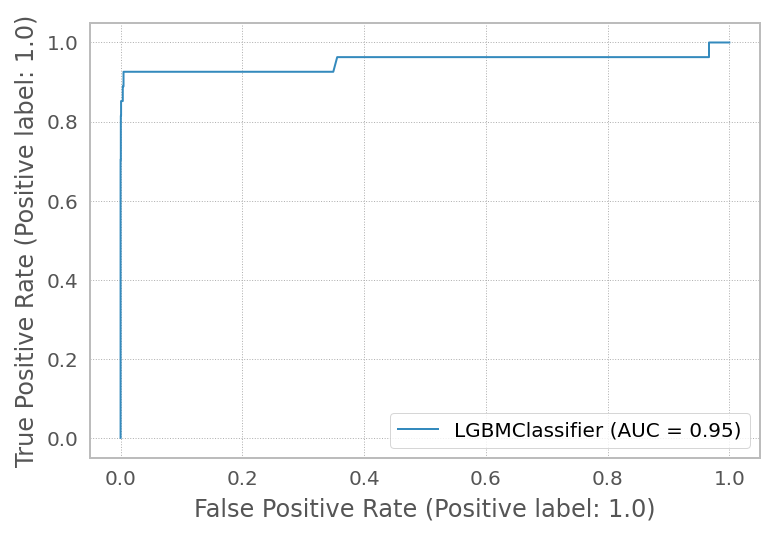

In [44]:
plot_roc_curve(model, X_test, y_test);

Согласно матрице смешения модель слишком консервативна, и не определяет некоторые аномалии:

In [45]:
cm  = confusion_matrix(y_test, preds)
cm
# array([[2487,    0],
#        [   5,   22]])

array([[2486,    1],
       [   7,   20]])

In [46]:
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print(f"Precision is: {precision}")
print(f"   Recall is: {recall}")
# Precision is: 1.0
#    Recall is: 0.8148148148148148

Precision is: 0.9523809523809523
   Recall is: 0.7407407407407407


Можно увеличить чувствительность модели за счет снижения порога:

In [47]:
preds03 = model.predict_proba(X_test)[:,1]>.2
cm  = confusion_matrix(y_test, preds03)
print(cm)
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print(f"Precision is: {precision}")
print(f"   Recall is: {recall}")

[[2486    1]
 [   5   22]]
Precision is: 0.9565217391304348
   Recall is: 0.8148148148148148


## Анализ ошибок

Аномалии, которые модель не может предсказать:

In [48]:
missed = (preds != y_test) & (y_test == 1)
missed = missed[missed]
missed

time
2019-06-18 21:20:00    True
2019-06-18 22:05:00    True
2019-06-19 11:35:00    True
2019-06-19 21:15:00    True
2019-06-20 06:00:00    True
2019-06-21 04:55:00    True
2019-06-24 13:35:00    True
Name: anomaly, dtype: bool

array([<AxesSubplot:ylabel='sum_count'>,
       <AxesSubplot:xlabel='time', ylabel='anomaly'>], dtype=object)

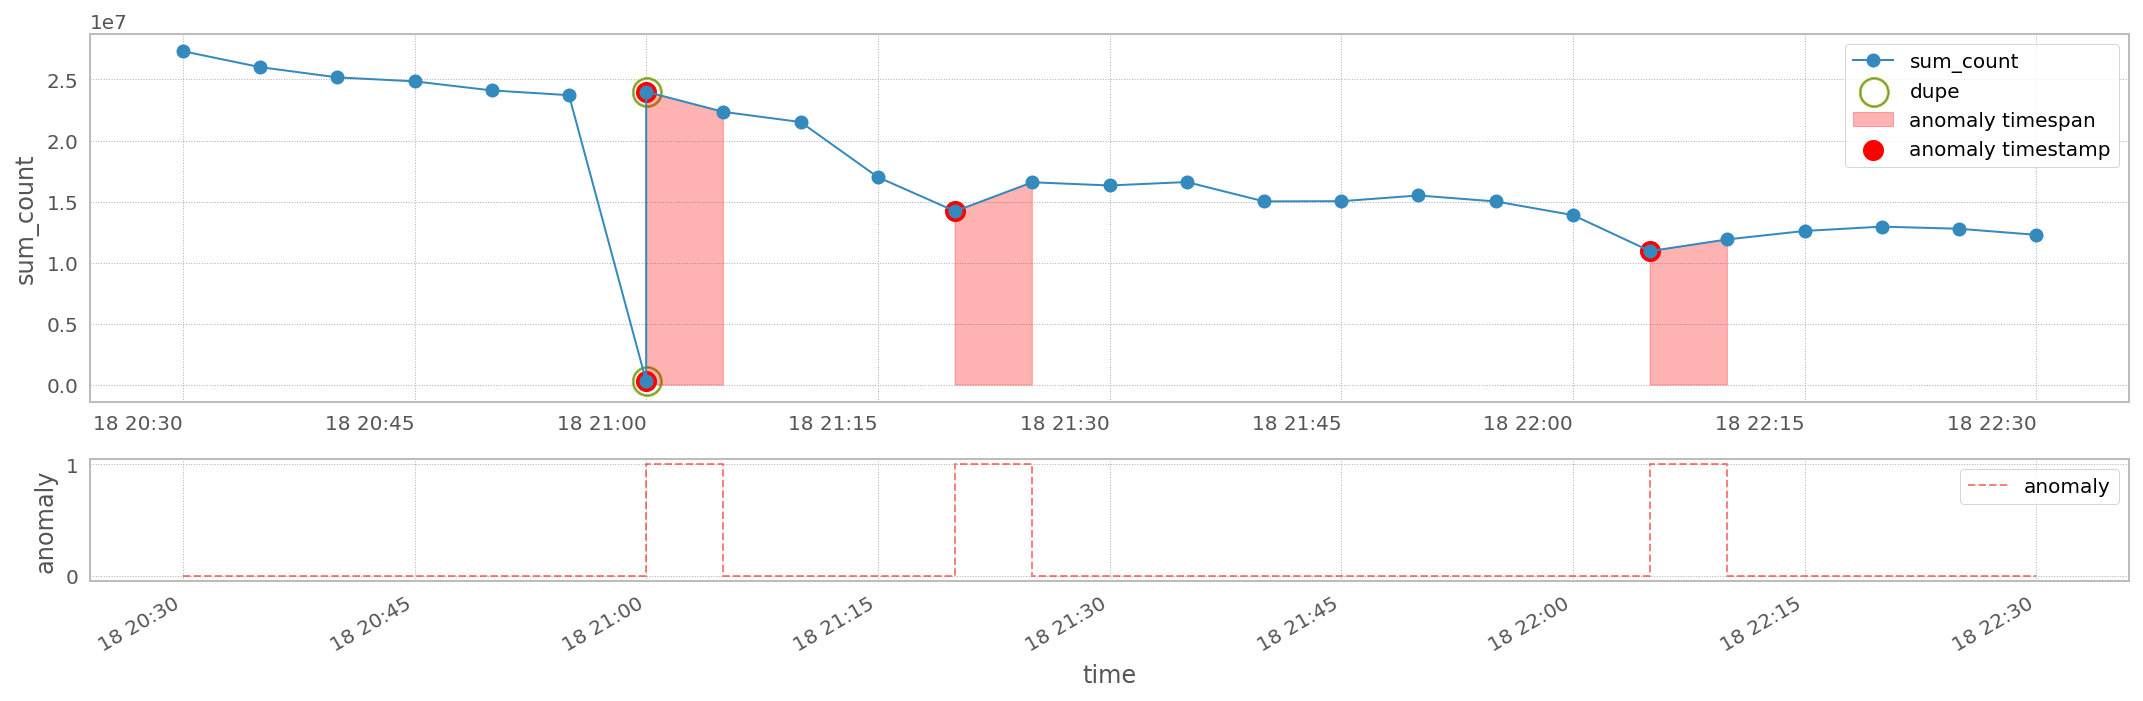

In [49]:
# missed
# 2019-06-18 21:20:00    True
# 2019-06-18 22:05:00    True

X_test_missed = X_test.copy()
X_test_missed['anomaly'] = y_test
X_test_missed = X_test_missed[pd.to_datetime('2019-06-18 20:30:00'):pd.to_datetime('2019-06-18 22:30:00')]
X_test_missed.reset_index(inplace=True)
plot_logs(X_test_missed)

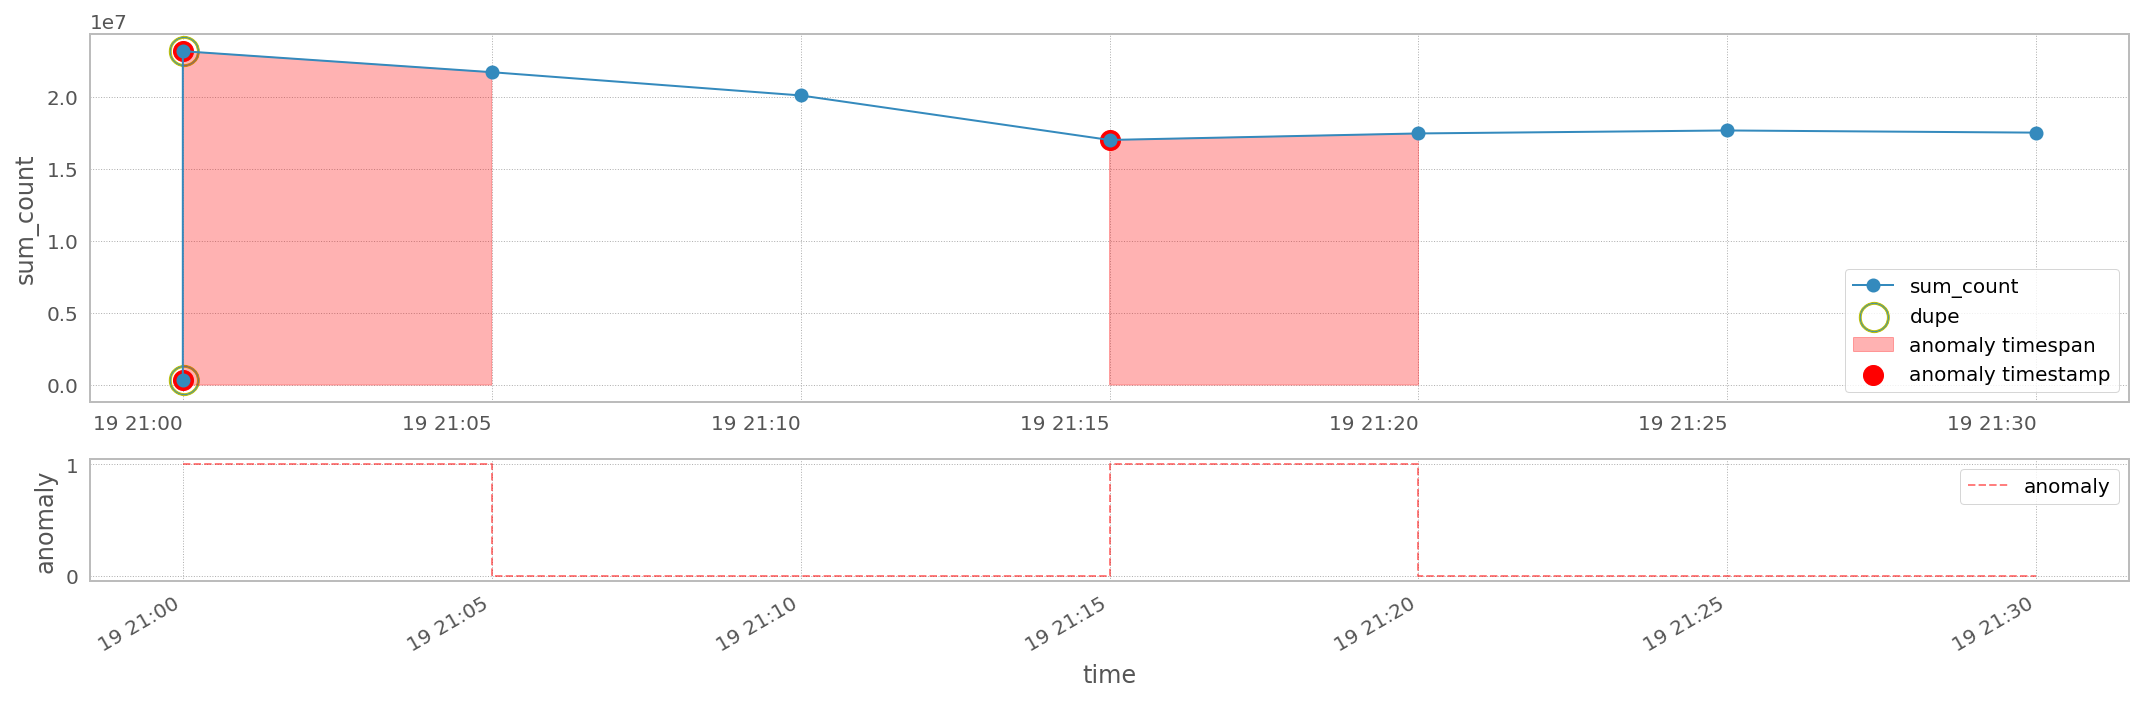

In [50]:
# missed
# 2019-06-19 21:15:00    True

X_test_missed = X_test.copy()
X_test_missed['anomaly'] = y_test
X_test_missed = X_test_missed[pd.to_datetime('2019-06-19 21:00:00'):pd.to_datetime('2019-06-19 21:30:00')]
X_test_missed.reset_index(inplace=True)
plot_logs(X_test_missed);

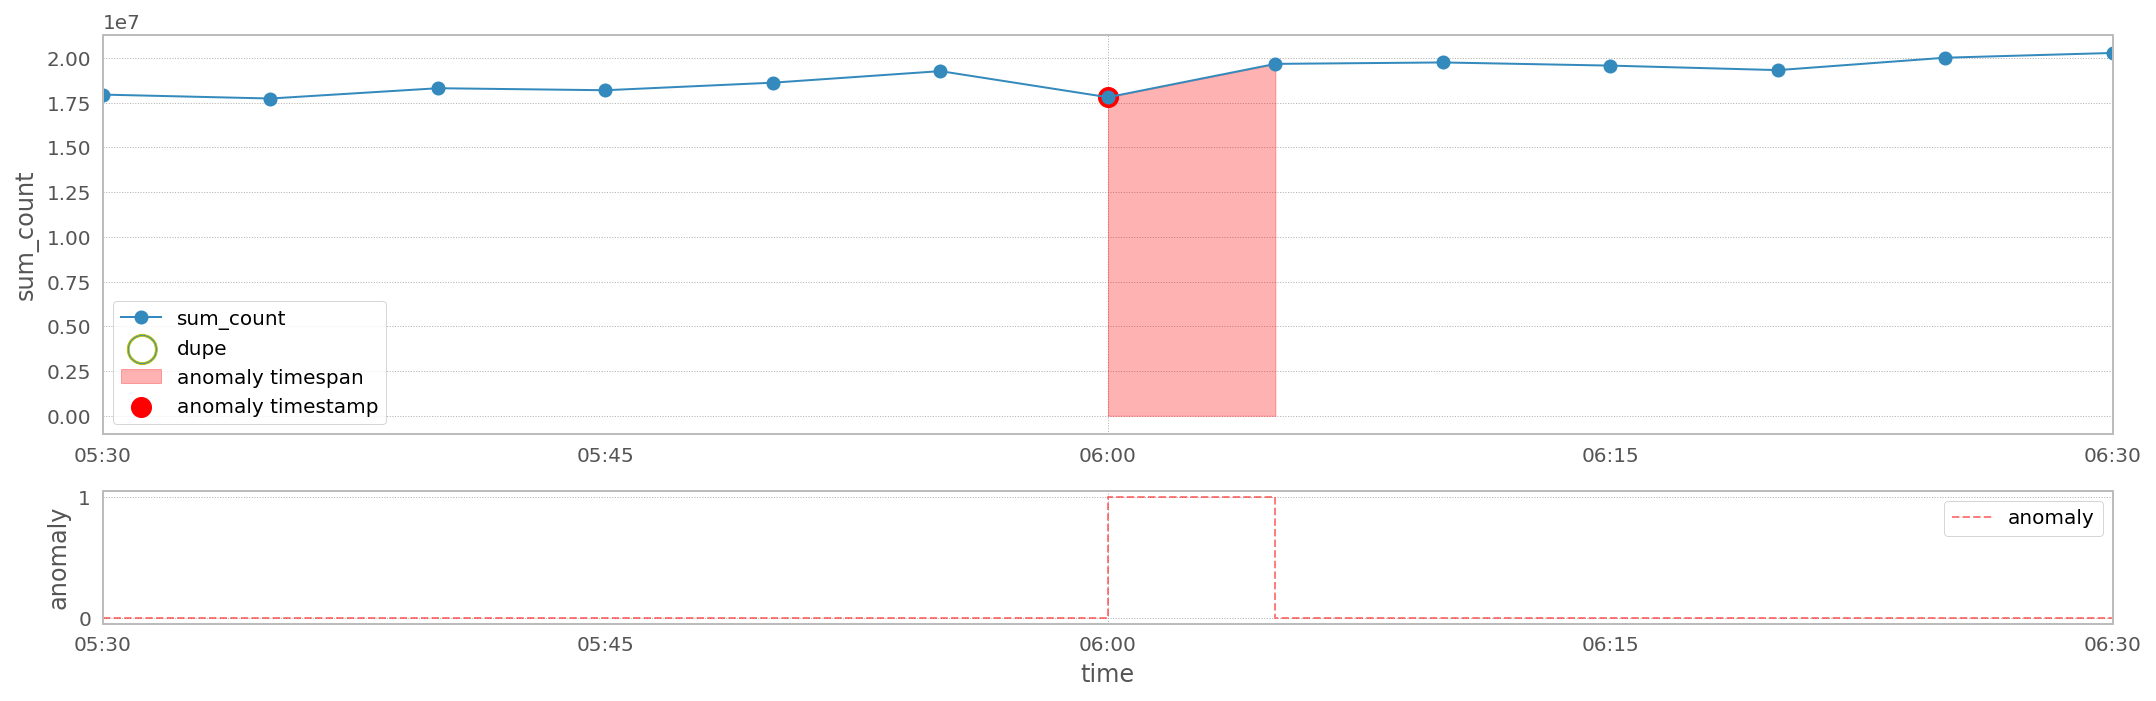

In [51]:
# missed
# 2019-06-20 06:00:00
X_test_missed = X_test.copy()
X_test_missed['anomaly'] = y_test
X_test_missed = X_test_missed[pd.to_datetime('2019-06-20 05:30:00'):pd.to_datetime('2019-06-20 06:30:00')]
X_test_missed.reset_index(inplace=True)
plot_logs(X_test_missed); 

Можно выдвинуть несколько гипотез, почему модель не определила аномалии:

    - предшествующий дубликат или аномалия с выбросом вниз могли сильно занизить скользящее среднее, что в результате не позволило распознать выброс вниз как аномалию
    - модель не воспринимает слишком маленькое отклонение вниз как аномалию (хотя визуально это отклонение определяется)  
    - другая, не известная причина определение данного лога как аномалия   
    
    Конкретную причину, почему модель посчитала данные точки как "0" (не аномалия), и какие фичи внесли какой вклад в это решение, можно определить при помощи SHAP:

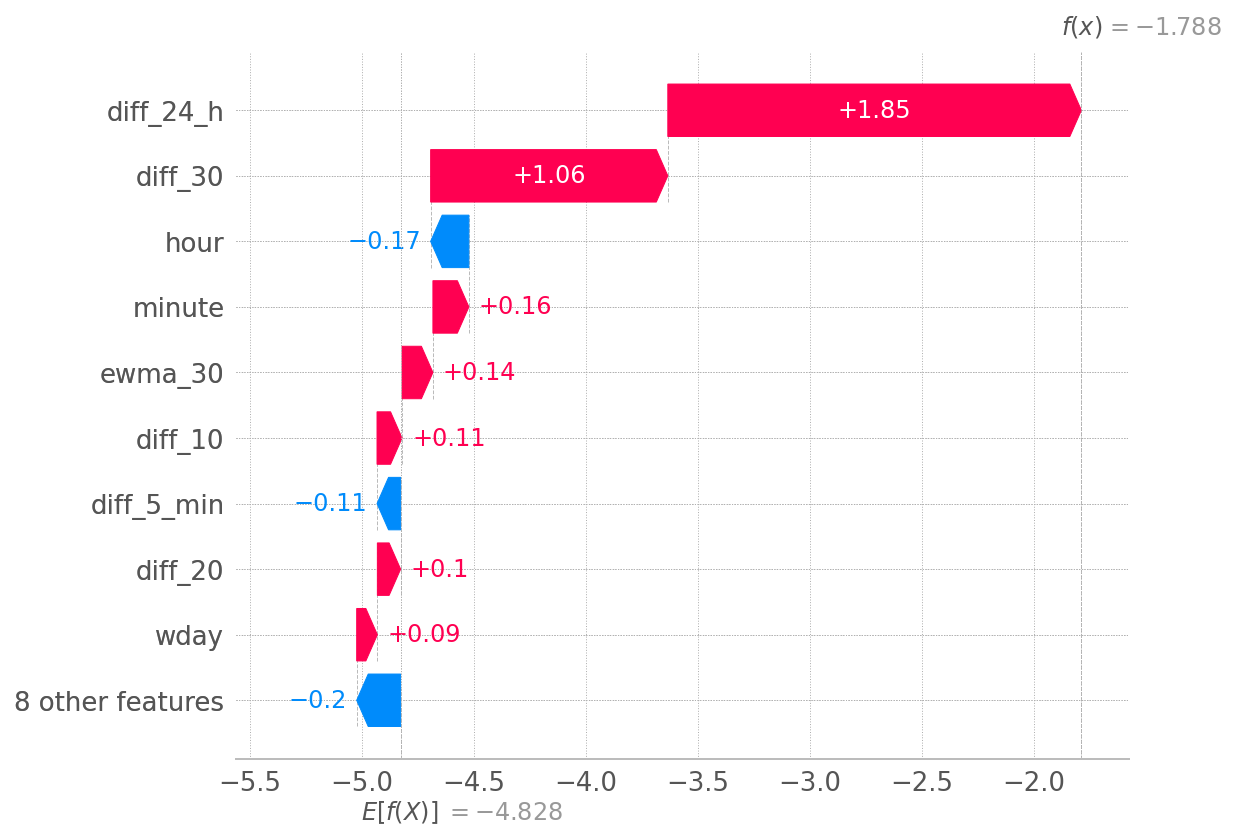

In [63]:
# 2019-06-18 21:20:00
explainer = Explainer(model)
x = X_test.loc[[missed.index[0]]]
shap_values = explainer(x)
sv = Explanation(values=shap_values.values[0,:,1], base_values=shap_values.base_values[0,1], feature_names=X_test.columns)
waterfall(sv, max_display=10)

In [64]:
# shap values show how raw model scores add up due to a feature
# i.e. average marginal logit contributions over all possible coalitions 
expit(-1.788), model.predict_proba(x)[0][1]

(0.14331810440312848, 0.1433259622867597)

Для сравнения, усредненный профайл точек, определенных как аномалия: 

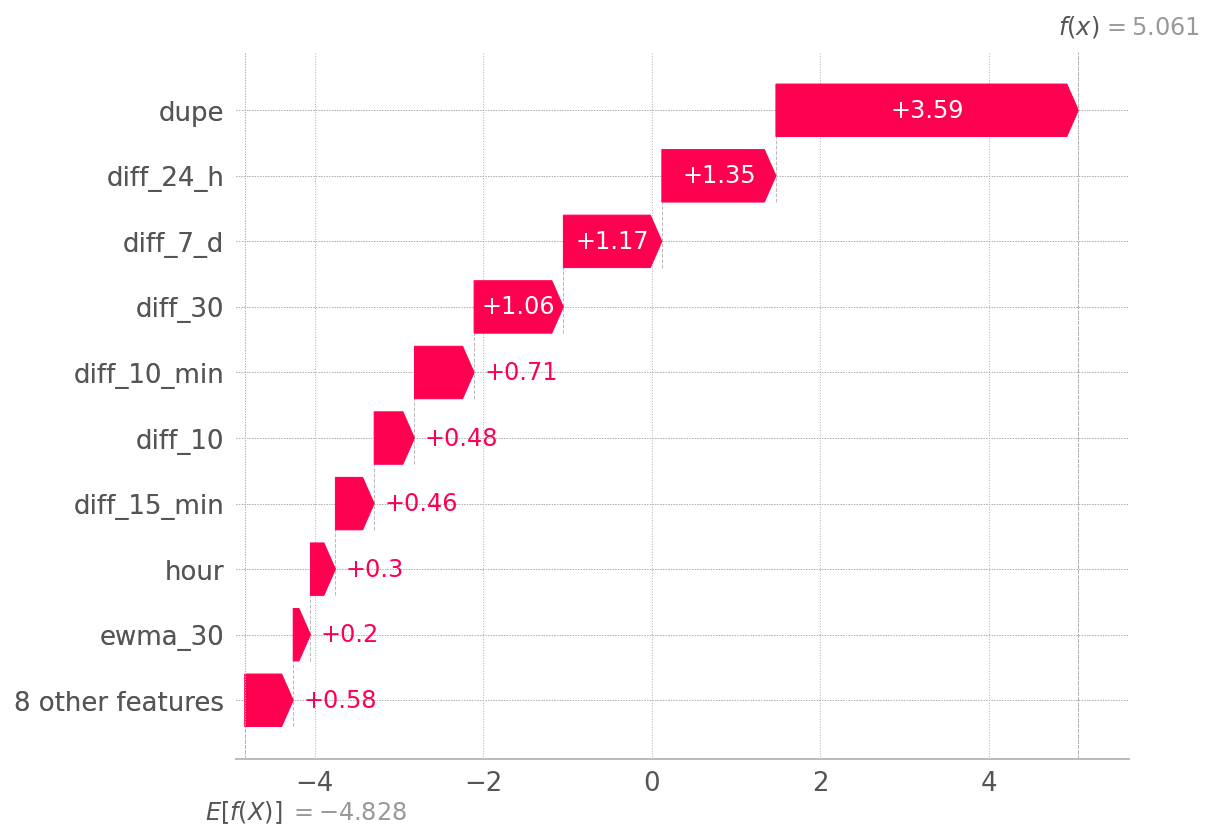

In [54]:
not_missed = (preds == y_test) & (y_test == 1)
not_missed = not_missed[not_missed]
x = X_test.loc[not_missed.index]
shap_values = explainer(x)
sv = Explanation(values=shap_values.values[0,:,1], base_values=shap_values.base_values[0,1], feature_names=X_test.columns)
waterfall(sv, max_display=10)

Сравнивая профайлы FN логов с усреденным профайлом TP логов можно сделать вывод:

> - в корректно определённых моделью аномалиях ВСЕ фичи работают в плюс  
> - в точках где мы имеем FN среди фич нет консенсуса: часть фич работает в плюс, часть в минус, что приводит к FN решению, что в свою очередь говорит о недостаточности данных   

## Потенциал улучшения     

1. Данные за бОльший промежуток времени (3+ года)    
2. Сбор и генерация дополнительных признаков согласно:  
    - бизнес логике определения аномалии   
    - определения причинно-следственной связи возникновения аномалий  
3. Определение дисперсии не за последние 10 промежутков, а для каждого 5-ти минутного периода 
3. Нейронные сети (LSTM/Conv1D + MaxPooling) с более сложной структурой входных данных, например вектор признаков + маска (дубликаты и/или точки уже опреленные как аномалия) 
4. Определение дубликатов как аномалий посредством счета логов. Обучение модели на датасете без дубликатов, помеченных как аномалия (см пример LightGBM.ipynb).  
5. Исследовать возможность применения ARIMA  
6. Блендинг/стэкинг с другими моделями  
7. Возможность предсказания аномалии онлайн (при последовательной подаче логов на вход, с онлайн ответом 0/1) 